In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [153]:
df = pd.read_csv(r'/content/Amazon.csv')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,4.075000,4.478125,3.952344,4.468750,4.468750,322352000.0,2000-01-03
1,4.268750,4.575000,4.087500,4.096875,4.096875,349748000.0,2000-01-04
2,3.525000,3.756250,3.400000,3.487500,3.487500,769148000.0,2000-01-05
3,3.565625,3.634375,3.200000,3.278125,3.278125,375040000.0,2000-01-06
4,3.350000,3.525000,3.309375,3.478125,3.478125,210108000.0,2000-01-07


In [154]:
df.shape

(5839, 7)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5834 non-null   float64
 1   High       5834 non-null   float64
 2   Low        5834 non-null   float64
 3   Close      5834 non-null   float64
 4   Adj Close  5834 non-null   float64
 5   Volume     5834 non-null   float64
 6   Date       5839 non-null   object 
dtypes: float64(6), object(1)
memory usage: 319.4+ KB


In [156]:
df['Date'] = pd.to_datetime(df['Date'])

In [157]:
df.duplicated().sum()

np.int64(0)

In [158]:
for col in df.columns[:-1]:
  df[col] = df[col].interpolate()

In [159]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Date
count,5839.000000,5839.000000,5839.000000,5839.000000,5839.000000,5.839000e+03,5839
mean,34.865788,35.281147,34.410556,34.853785,34.853785,1.239742e+08,2011-08-11 11:01:25.699606016
min,0.295500,0.305000,0.275500,0.298500,0.298500,1.762600e+07,2000-01-03 00:00:00
25%,2.209188,2.252750,2.175000,2.221500,2.221500,6.798200e+07,2005-10-22 12:00:00
50%,9.449500,9.570000,9.285500,9.437500,9.437500,1.015500e+08,2011-08-10 00:00:00
75%,47.835499,48.138500,47.507500,47.833000,47.833000,1.479700e+08,2017-05-30 12:00:00
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09,2023-03-17 00:00:00
std,49.577206,50.162594,48.924441,49.540911,49.540911,9.908337e+07,NaN


Text(0.5, 1.0, 'Close')

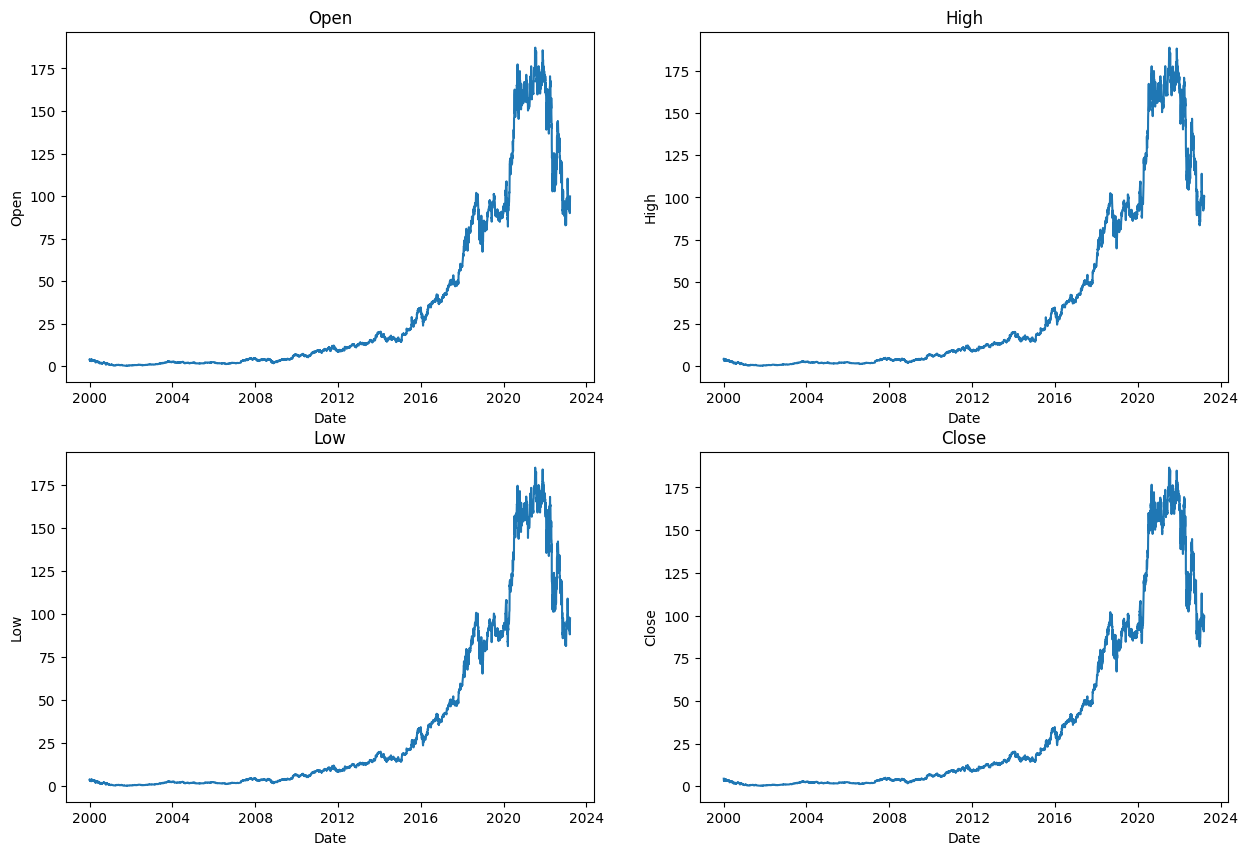

In [160]:
fig, ax = plt.subplots(2,2,figsize=(15, 10))
sns.lineplot(x=df['Date'], y = df['Open'], ax= ax[0,0]).set_title('Open')
sns.lineplot(x=df['Date'], y = df['High'], ax= ax[0,1]).set_title('High')
sns.lineplot(x=df['Date'], y = df['Low'], ax= ax[1,0]).set_title('Low')
sns.lineplot(x=df['Date'], y = df['Close'], ax= ax[1,1]).set_title('Close')

<Axes: title={'center': 'All'}, xlabel='Date', ylabel='Open'>

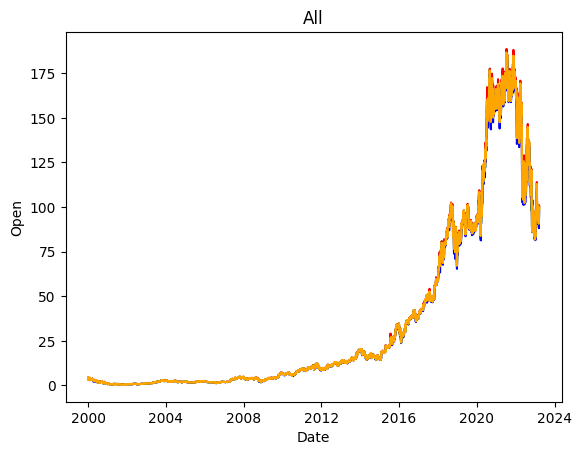

In [161]:
fig, ax = plt.subplots()
sns.lineplot(x=df['Date'], y = df['Open'],color='g').set_title('All')
sns.lineplot(x=df['Date'], y = df['High'],color='r')
sns.lineplot(x=df['Date'], y = df['Low'],color='b')
sns.lineplot(x=df['Date'], y = df['Close'],color='y')
sns.lineplot(x=df['Date'], y = df['Adj Close'],color='orange')

Text(0.5, 1.0, 'volume')

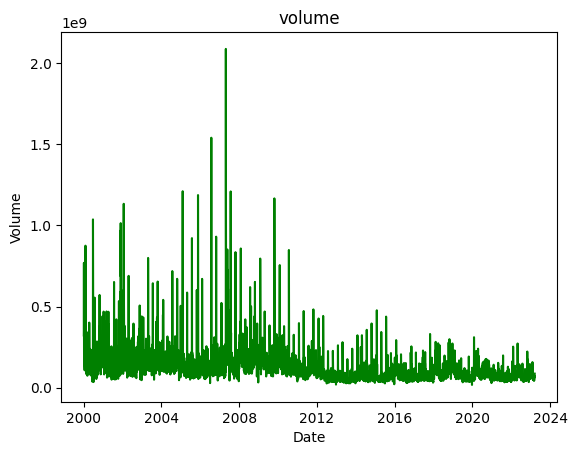

In [162]:
fig, ax = plt.subplots()
sns.lineplot(x= df['Date'], y = df['Volume'], color= 'g').set_title('volume')

In [163]:
df['Year'] = df['Date'].dt.year
group= df.groupby('Year')['Volume'].sum().reset_index()


Text(0.5, 1.0, 'volume')

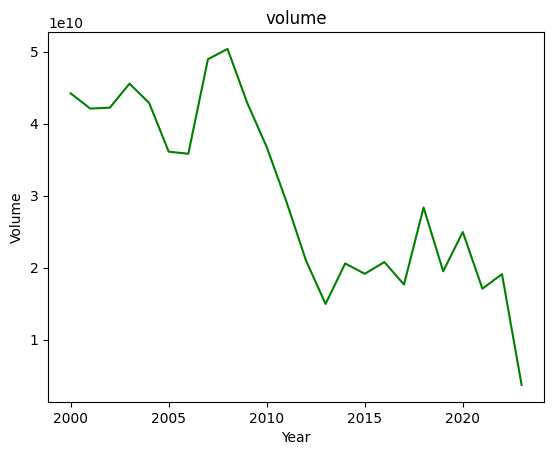

In [164]:
fig, ax = plt.subplots()
sns.lineplot(x= group['Year'], y = group['Volume'], color= 'g').set_title('volume')

In [165]:
df.drop(df[['Year','Date']],axis=1, inplace= True)

In [166]:
d = df.columns
def transfo(df,d=None,num=int):

  for i in range(1,num+1):
        for j in d:
            df[f'{j}{i}'] = df[j].shift(-i)
  for j in range(1,8):
      df[f'Target{j}'] = df['Close'].shift(-(num+j))
  return df

In [167]:
num= 3
df1 = transfo(df,d,num-1)
df1.dropna(inplace=True)

<Axes: >

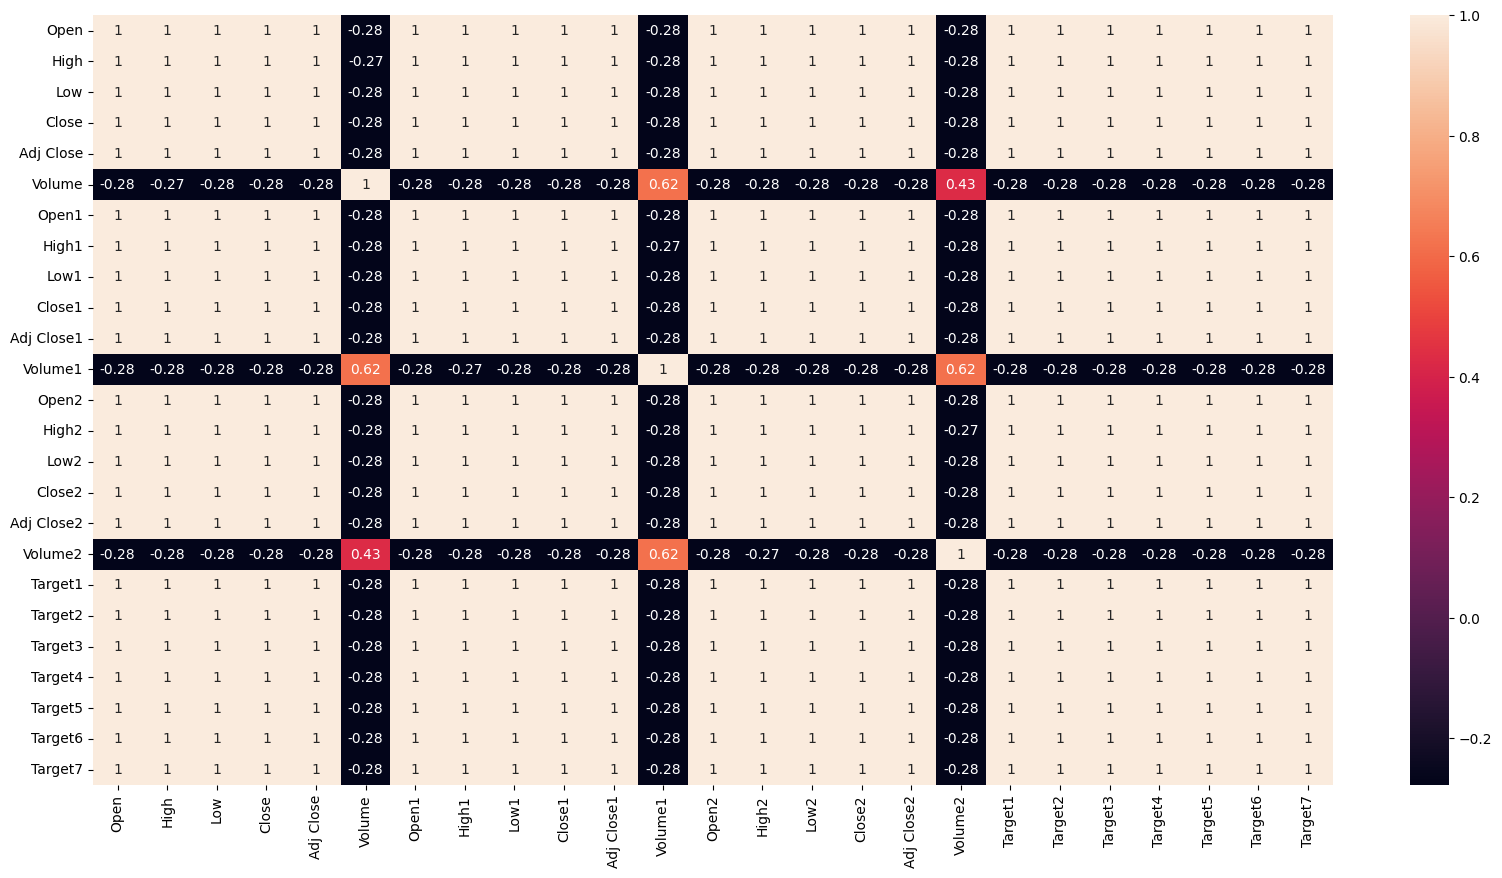

In [169]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df1.corr(),annot=True)

In [171]:
x= df1.iloc[:,:18]
y= df1.iloc[:,18:]
target = round(len(df1)*0.8,0)
x_train= x.iloc[:int(target),:]
x_test= x.iloc[int(target):,:]
y_train= y.iloc[:int(target),:]
y_test= y.iloc[int(target):,:]

In [172]:
transfo = ColumnTransformer(transformers=[
    ('mahoa',StandardScaler(),['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open1', 'High1',
       'Low1', 'Close1', 'Adj Close1', 'Volume1', 'Open2', 'High2', 'Low2',
       'Close2', 'Adj Close2', 'Volume2'])
])

In [173]:
model = [LinearRegression() for _ in range(7)]
for i in range(1,8):
    pipe = Pipeline(steps=[
          ('transfo', transfo),
          ('model', model[i-1])
    ])
    pipe.fit(x_train,y_train[f"Target{i}"])
    results = pipe.predict(x_test)
    print(f'Prediction day {i}: {r2_score(y_test[f"Target{i}"],results)}')

Prediction day 1: 0.9928210597722846
Prediction day 2: 0.9859380217432437
Prediction day 3: 0.9784074601615773
Prediction day 4: 0.9713955474844933
Prediction day 5: 0.9636811644722004
Prediction day 6: 0.9558731411488002
Prediction day 7: 0.9476792883042152
